In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dateutil import parser
from datetime import datetime
import time
from random import randint
from statistics import mode, median
import json
import numpy as np
import dataframe_image as dfi
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
# dpi = 120

# Load Data

In [3]:
# Load the data and print details
data = pd.read_csv('BigData/Characteristics_Corona_patients version 5 25-9-20.csv')

print("Columns:")
for x in list(data.columns):
    print(x)

print("Number of data points")
print(len(data.index))

C:\Users\Abubakar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,4,7,8,10,12,13,14,15,16,18,19,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns:
age
age_band
background_diseases
background_diseases_binary
city
confirmed_date
country
date_onset_symptoms
deceased_date
id
infected_by
origin
region
released_date
return_date
severity_illness
sex
smoking
symptoms
treatment
confirmed_date_D
deceased_date_D
released_date_D
return_date_D
date_onset_symptoms_D
return_date_until_date_onset_symptoms
date_onset_symptoms_until_confirmed_date
confirmed_date_until_released_date
confirmed_date_until_deceased_date
severity_illness_infectious_person
len_people_infected_by_patient
Number of data points
3963914


# Data Transformations

In [4]:
# Group outcomes into low - high
data['severity_illness'].replace(to_replace =['asymptomatic', 'cured', 'good'], value ="low", inplace=True)
data['severity_illness'].replace(to_replace =['critical', 'deceased'], value ="high", inplace=True)

In [5]:
# Drop all entries without an outcome
data = data[pd.notnull(data['severity_illness'])]
print(len(data))

966294


In [6]:
# find unique background_diseases 
print("background_diseases is missing " + str((sum(pd.isnull(data['background_diseases'])) / len(data['background_diseases'])) * 100) + "% of its data")

temp = data[pd.notnull(data['background_diseases'])]

diseases = set()


def search(row):
    if type(row['background_diseases']) == type("string"):
        for d in row['background_diseases'].split(','):
            diseases.add('disease(' + d.strip() + ')')
            
    return row

temp = temp.apply(search, axis=1)

print(diseases)

background_diseases is missing 96.69924474331829% of its data
{'disease(brain haemorrhage)', 'disease(valvular heart disease)', 'disease(on dialysis)', 'disease(colon cancer)', 'disease(thalassemia)', 'disease(atherosclerotic)', 'disease(asthma)', 'disease(benign prostatic hyperplasia)', 'disease(tongue cancer)', 'disease(hiv)', 'disease(hypertriglyceridemia)', 'disease(cardiomyopathy)', 'disease(diabetic nephropathy)', 'disease(frequent ventricular premature beat)', 'disease(kidney failure)', 'disease(prostate cancer)', 'disease(obesity)', 'disease(coronary bypass surgery)', 'disease(myeloma)', 'disease(atrial fibrillation)', 'disease(stenocardia)', 'disease(hepatitis B)', 'disease(parkinson)', 'disease(hypertension)', 'disease(tuberculosis)', 'disease(dyslipidemia)', 'disease(gastrointestinal bleeding)', 'disease(prostat cancer)', 'disease(leukemia)', 'disease(chronic obstructive pulmonary disease)', 'disease(stent  implanted)', 'disease(encephalomalacia)', 'disease(vestibular disord

In [8]:
# Create coulmns for each unique disease
for i in diseases:
    if len(i) != 0:
        data[i] = [0]*len(data)
        
# Create column for number of pre-existing conditions
data['num_of_prexisting_conditions'] = [0]*len(data)

In [9]:
# Fill disease columns by parsing 'background_diseases' column. 
# At the same time, update number of prexsting conditions accordingly

idx_to_change = {}

def encode(row):
    if type(row['background_diseases']) == type("string"):
        for d in row['background_diseases'].split(','): 
            d_column = d.strip()
            if d_column in idx_to_change.keys():
                idx_to_change['disease(' + d_column + ')'].append(row.name)
            else:
                idx_to_change['disease(' + d_column + ')'] = [row.name]
                
            # Update values
            if d_column == 'prostat cancer':
                data.loc[row.name, 'disease(prostate cancer)'] = 1
            elif len(d_column) == 0:
                continue
            else:
                data.loc[row.name, 'disease(' + d_column + ')'] = 1

            data.loc[row.name, 'num_of_prexisting_conditions'] = data['num_of_prexisting_conditions'][row.name] + 1
            
            
            
    return row

data.apply(encode, axis=1).head()

966294


,age,age_band,background_diseases,background_diseases_binary,city,confirmed_date,country,date_onset_symptoms,deceased_date,id,infected_by,origin,region,released_date,return_date,severity_illness,sex,smoking,symptoms,treatment,confirmed_date_D,deceased_date_D,released_date_D,return_date_D,date_onset_symptoms_D,return_date_until_date_onset_symptoms,date_onset_symptoms_until_confirmed_date,confirmed_date_until_released_date,confirmed_date_until_deceased_date,severity_illness_infectious_person,len_people_infected_by_patient,disease(brain haemorrhage),disease(valvular heart disease),disease(on dialysis),disease(colon cancer),disease(thalassemia),disease(atherosclerotic),disease(asthma),disease(benign prostatic hyperplasia),disease(tongue cancer),disease(hiv),disease(hypertriglyceridemia),disease(cardiomyopathy),disease(diabetic nephropathy),disease(frequent ventricular premature beat),disease(kidney failure),disease(prostate cancer),disease(obesity),disease(coronary bypass surgery),disease(myeloma),disease(atrial fibrillation),disease(stenocardia),disease(hepatitis B),disease(parkinson),disease(hypertension),disease(tuberculosis),disease(dyslipidemia),disease(gastrointestinal bleeding),disease(prostat cancer),disease(leukemia),disease(chronic obstructive pulmonary disease),disease(stent implanted),disease(encephalomalacia),disease(vestibular disorders),disease(lung cancer),disease(atherosclerosis),disease(gastritis),disease(coronary heart disease),disease(diabetes),disease(endocrine condition),disease(hypothyroidism),disease(peripheral arterial occlusive disease),disease(immunosuppression),disease(hypertensive nephrosclerosis),disease(chronic kidney disease),disease(renal transplant),disease(cardiovascular),disease(hip replacement),disease(prostate hypertrophy),disease(cerebral infarction),disease(arrhythmia),disease(chronic obstructive pulmonary),disease(impaired fasting glucose),disease(),disease(pneumonia),disease(azotemia),num_of_prexisting_conditions
0,NaN,NaN,NaN,NaN,NaN,2020-02-28,france,NaN,NaN,0,NaN,france,Nouvelle-Aquitaine,2020-02-03,NaN,low,NaN,NaN,NaN,hospitalized,423.0,NaN,398.0,NaN,NaN,NaN,NaN,-25.0,NaN,NaN,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,2020-02-28,france,NaN,NaN,1,NaN,france,Nouvelle-Aquitaine,NaN,NaN,low,NaN,NaN,NaN,hospitalized,423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,2020-02-28,france,NaN,NaN,2,NaN,france,Nouvelle-Aquitaine,NaN,NaN,low,NaN,NaN,NaN,hospitalized,423.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,2020-03-03,france,NaN,NaN,3,NaN,france,Nouvelle-Aquitaine,2020-03-06,NaN,low,NaN,NaN,NaN,hospitalized,427.0,NaN,430.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,2020-03-05,france,NaN,NaN,4,NaN,france,Nouvelle-Aquitaine,NaN,NaN,low,NaN,NaN,NaN,home isolation,429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# find distribution of "severity_illness" values
j = set()
h = {'low': 0, 'high': 0}
for i in data.index:
    j.add(data["severity_illness"][i])
    h[data["severity_illness"][i]] = h[data["severity_illness"][i]] + 1

j = list(j)

In [12]:
data.drop('disease(prostat cancer)', axis=1, inplace=True) # Is a duplicate caused by a spelling error

In [13]:
# Process country column to identify all unique countries in dataset
countries = list(set(data['country']))
countries.remove(np.nan)
countries.sort()

In [14]:
# Remove non-country entries and duplicates
data.replace(to_replace='foreign', value=np.nan, inplace=True)
data.replace(to_replace='middleeast', value=np.nan, inplace=True)
data.replace(to_replace='africa', value=np.nan, inplace=True)
data.replace(to_replace='unitedarabemirates', value='united arab emirates', inplace=True)
data.replace(to_replace='unitedkingdom', value='united kingdom', inplace=True)

# Plots describing original dataset

In [15]:
# Original Distribution of missing data

table = pd.DataFrame({
    'Mode': data.mode().iloc[0],
    'Number of unique values': [len(data[x].unique()) for x in data.columns],
    'Percent Missing': (data.isna().sum()/len(data))*100,
})


# Save image
dfi.export(table.style.background_gradient(), "New_Figures/data_exploration/missing_data_original_distribution_with_added_columns.png", max_rows=-1)  #missing_data_original_distribution

table

,Mode,Number of unique values,Percent Missing
age,30,118,12.176004
age_band,30,13,10.524851
background_diseases,"diabetes, hypertension,",264,96.699245
background_diseases_binary,0,3,84.275490
city,Bogotá D.C.,3027,6.731492
confirmed_date,2020-08-11,255,1.796555
country,colombia,79,0.052779
date_onset_symptoms,2020-07-24,274,21.478039
deceased_date,2020-07-06,233,92.777871
id,0,966294,0.000000


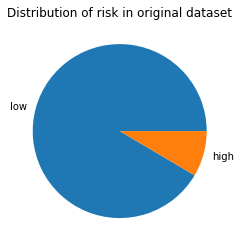

,Risk,Percentage
0,low,91.501137
1,high,8.498863


In [16]:
# Distribution of outcomes
plt.pie([h['low'], h['high']], labels=['low', 'high'])
plt.title("Distribution of risk in original dataset")
plt.savefig("New_Figures/data_exploration/risk_original_distribution_pie.png", bbox_inches='tight') # Save image
plt.show()

temp = pd.DataFrame(
    {
        'Risk': ['low', 'high'],
        'Percentage': [(h['low']/len(data)*100), (h['high']/len(data)*100)],
    }
)

# Save image
dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/risk_original_distribution_table.png")

temp

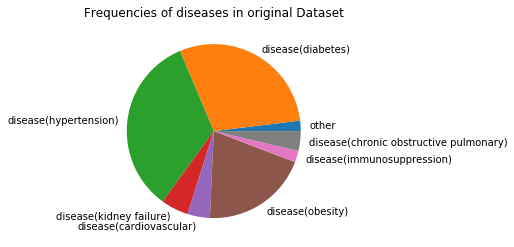

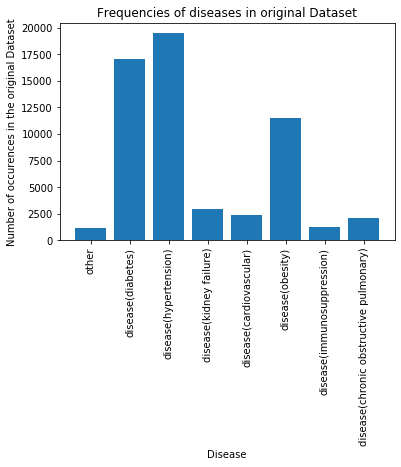

,Disease,Percentage
0,disease(diabetes),1.763645
1,disease(hypertension),2.018537
2,disease(coronary heart disease),0.001656
3,disease(kidney failure),0.306222
4,disease(chronic kidney disease),0.003726
5,disease(asthma),0.100591
6,disease(endocrine condition),0.000103
7,disease(valvular heart disease),0.000207
8,disease(renal transplant),0.000103
9,disease(pneumonia),0.000103


In [17]:
# Disease Frequency graph
names = ['other']
values = [0]
temp = {'Disease': [], 'Percentage': []}

for key in idx_to_change.keys():
    if len(key) != 0 and key != 'disease(prostat cancer)':
        temp['Disease'].append(key)
        temp['Percentage'].append(sum(data[key])/len(data)*100)
        if sum(data[key]) > 1000:
            names.append(key)
            values.append(sum(data[key]))
        else:
            values[0] = values[0] + sum(data[key])     


plt.pie(values, labels=names)
plt.title("Frequencies of diseases in original Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/original_disease_frequency_pie.png", bbox_inches='tight')
plt.show()

plt.bar(names, values)
plt.xlabel("Disease")
plt.ylabel("Number of occurences in the original Dataset")
plt.title("Frequencies of diseases in original Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/original_disease_frequency_bar.png", bbox_inches='tight')
plt.show()


temp = pd.DataFrame(temp)

# Save image
dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/original_disease_frequency_table.png")

temp

In [19]:
country_columns = ['country_algeria', 'country_andorra', 'country_argentina', 'country_australia', 'country_bahamas', 'country_belgium', 'country_benin', 'country_bhutan', 'country_bolivia', 'country_brazil', 'country_burkinafaso', 'country_caboverde', 'country_cambodia', 'country_cameroon', 'country_chile', 'country_china', 'country_colombia', 'country_cuba', 'country_czechrepublic', 'country_equatorialguinea', 'country_eswatini', 'country_ethiopia', 'country_france', 'country_gabon', 'country_gambia', 'country_germany', 'country_guatemala', 'country_guyana', 'country_hongkong', 'country_india', 'country_indonesia', 'country_italy', 'country_japan', 'country_kazakhstan', 'country_kuwait', 'country_liberia', 'country_lithuania', 'country_malaysia', 'country_mexico', 'country_namibia', 'country_nepal', 'country_netherlands', 'country_niger', 'country_nigeria', 'country_oman', 'country_philippines', 'country_puertorico', 'country_qatar', 'country_reunion', 'country_romania', 'country_russia', 'country_sanmarino', 'country_saudiarabia', 'country_singapore', 'country_southkorea', 'country_spain', 'country_sudan', 'country_switzerland', 'country_tanzania', 'country_thailand', 'country_togo', 'country_tunisia', 'country_united arab emirates', 'country_united kingdom', 'country_unitedstates', 'country_vietnam', 'country_zimbabwe']

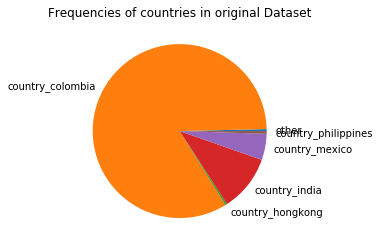

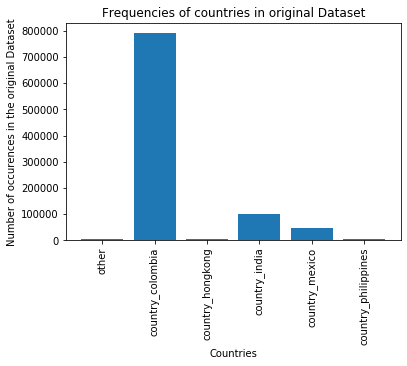

,Country,Percentage
0,country_algeria,0.000931
1,country_andorra,0.000103
2,country_argentina,0.000310
3,country_australia,0.002691
4,country_bahamas,0.000310
5,country_belgium,0.000724
6,country_benin,0.000310
7,country_bhutan,0.000207
8,country_bolivia,0.000414
9,country_brazil,0.006830


In [20]:
# Country frequency graphs
country_frequency = [0]
temp_countries = ["other"]
temp = {'Country': [], 'Percentage': []}

for country in country_columns:
    temp['Country'].append(country)
    temp['Percentage'].append(len(data[data['country'] == country[8:]])/len(data)*100)
    if len(data[data['country'] == country[8:]]) > 1000: # unless a country appears more than 1000 times, put it into other
        country_frequency.append(len(data[data['country'] == country[8:]]))
        temp_countries.append(country)
    elif country == "None":
        pass
    else:
        country_frequency[0] = country_frequency[0] + len(data[data['country'] == country[8:]])


plt.pie(country_frequency, labels=temp_countries)
plt.title("Frequencies of countries in original Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/original_country_frequency_pie.png", bbox_inches='tight')
plt.show()

plt.bar(temp_countries, country_frequency)
plt.xlabel("Countries")
plt.ylabel("Number of occurences in the original Dataset")
plt.title("Frequencies of countries in original Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/original_country_frequency_bar.png", bbox_inches='tight')
plt.show()

temp = pd.DataFrame(temp)

# Save image
dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/original_country_frequency_table.png")

temp

# Data changes

In [21]:
# Extract columns we are not interested in
data.drop(['background_diseases_binary',
           'age_band',
           'city',
           'symptoms',
           'confirmed_date',
           'date_onset_symptoms',
           'deceased_date',
           'smoking',
           'treatment',
           'id',
           'infected_by',
           'origin',
           'region',
           'released_date',
           'return_date',
           'confirmed_date_D',
           'deceased_date_D',
           'released_date_D',
           'return_date_D',
           'date_onset_symptoms_D',
           'return_date_until_date_onset_symptoms',
           'date_onset_symptoms_until_confirmed_date',
           'confirmed_date_until_released_date',
           'confirmed_date_until_deceased_date',
           'severity_illness_infectious_person',
           'len_people_infected_by_patient'
          ], axis=1, inplace=True)

In [22]:
# Only take rows with known target
data = data[pd.notnull(data['severity_illness'])]

# Remove all rows with missing data
data = data[pd.notnull(data['sex'])]
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['age'])]

# index correction
data.reset_index(drop=True, inplace=True)

In [23]:
# Convert sex column into two seperate columns to make processing easier
data = pd.get_dummies(data, columns=['sex'])

In [24]:
# Remove redundant column
data.drop(['background_diseases'], axis=1, inplace=True)
# data.drop(['symptoms'], axis=1, inplace=True)

In [25]:
# find distribution of "severity_illness" values in new dataset
j = set()
h = {'low': 0, 'high': 0}
for i in data.index:
    j.add(data["severity_illness"][i])
    h[data["severity_illness"][i]] = h[data["severity_illness"][i]] + 1

j = list(j)

In [26]:
# Save these indeces. They take forever to process
json.dump(idx_to_change, open("idx_to_change_v9.json",'w'))
# json.dump(idx_to_change_symptoms, open("idx_to_change_symptoms_v9.json",'w'))

In [27]:
# Reset indeces and save dataset
data.reset_index(drop=True, inplace=True)

data.to_csv('BigData/data_V10.csv', index=False) 

# Plots describing final dataset

In [28]:
# New Distribution of missing data
table = pd.DataFrame({
    'Mode': data.mode().iloc[0],
    'Number of unique values': [len(data[x].unique()) for x in data.columns],
    'Percent Missing': (data.isna().sum()/len(data))*100,
})

dfi.export(table.style.background_gradient(), "New_Figures/data_exploration/missing_data_new_distribution_with_added_columns.png", max_rows=-1) 

table


,Mode,Number of unique values,Percent Missing
age,30,117,0.0
country,colombia,67,0.0
severity_illness,low,2,0.0
disease(brain haemorrhage),0,2,0.0
disease(valvular heart disease),0,2,0.0
disease(on dialysis),0,1,0.0
disease(colon cancer),0,2,0.0
disease(thalassemia),0,2,0.0
disease(atherosclerotic),0,2,0.0
disease(asthma),0,2,0.0


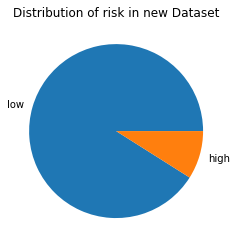

,Risk,Percentage
0,low,91.029904
1,high,8.970096


In [29]:
# Distribution of outcomes
plt.pie([h['low'], h['high']], labels=['low', 'high'])
plt.title("Distribution of risk in new Dataset")
plt.savefig("New_Figures/data_exploration/risk_new_distribution_pie.png", bbox_inches='tight')
plt.show()

temp = pd.DataFrame(
    {
        'Risk': ['low', 'high'],
        'Percentage': [(h['low']/len(data)*100), (h['high']/len(data)*100)],
    }
)


dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/risk_new_distribution_table.png")

temp

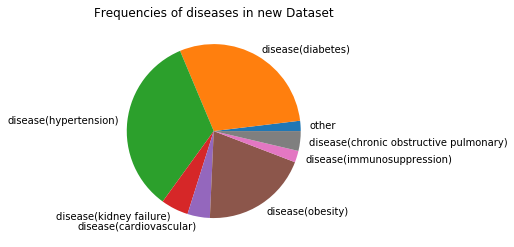

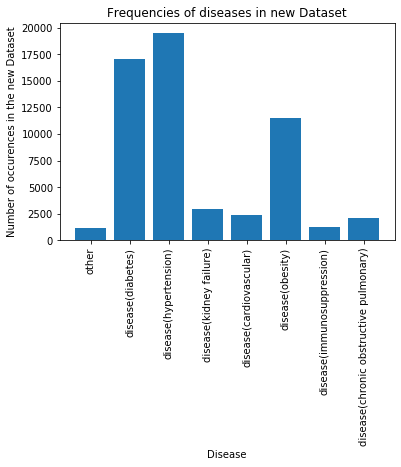

,Disease,Percentage
0,disease(diabetes),2.008919
1,disease(hypertension),2.299562
2,disease(coronary heart disease),0.001887
3,disease(kidney failure),0.348890
4,disease(chronic kidney disease),0.004009
5,disease(asthma),0.114607
6,disease(endocrine condition),0.000118
7,disease(valvular heart disease),0.000236
8,disease(renal transplant),0.000118
9,disease(pneumonia),0.000118


In [30]:
# Frequency graph
names = ['other']
values = [0]
temp = {'Disease': [], 'Percentage': []}

for key in idx_to_change.keys():
    if len(key) != 0 and key != 'disease(prostat cancer)':
        temp['Disease'].append(key)
        temp['Percentage'].append(sum(data[key])/len(data)*100)
        if sum(data[key]) > 1000:
            names.append(key)
            values.append(sum(data[key]))
        else:
            values[0] = values[0] + sum(data[key])     


plt.pie(values, labels=names)
plt.title("Frequencies of diseases in new Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/new_disease_frequency_pie.png", bbox_inches='tight')
plt.show()

plt.bar(names, values)
plt.xlabel("Disease")
plt.ylabel("Number of occurences in the new Dataset")
plt.title("Frequencies of diseases in new Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/new_disease_frequency_bar.png", bbox_inches='tight')
plt.show()

temp = pd.DataFrame(temp)

dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/new_disease_frequency_table.png")

temp

In [38]:
# Country frequency graphs
country_frequency = [0]
temp_countries = ["other"]
temp = {'Country': [], 'Percentage': []}

for country in country_columns:
    temp['Country'].append(country)
    temp['Percentage'].append(len(data[data['country'] == country[8:]])/len(data)*100)
    if len(data[data['country'] == country[8:]]) > 1000:
        country_frequency.append(len(data[data['country'] == country[8:]]))
        temp_countries.append(country)
    elif country == "None":
        pass
    else:
        country_frequency[0] = country_frequency[0] + len(data[data['country'] == country[8:]])


plt.pie(country_frequency, labels=temp_countries)
plt.title("Frequencies of countries in Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/new_country_frequency_pie.png", bbox_inches='tight')
plt.show()

plt.bar(temp_countries, country_frequency)
plt.xlabel("Countries")
plt.ylabel("Number of occurences in the new Dataset")
plt.title("Frequencies of countries in new Dataset")
plt.xticks(rotation=90)
plt.savefig("New_Figures/data_exploration/new_country_frequency_bar.png", bbox_inches='tight')
plt.show()

temp = pd.DataFrame(temp)

dfi.export(temp.style.background_gradient(), "New_Figures/data_exploration/new_country_frequency_table.png")

temp

In [39]:
# Sort countries by frequency
zipped_lists = zip(temp['Percentage'], temp['Country'])
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)

temp['Percentage'], temp['Country'] = [ list(tuple) for tuple in  tuples]

In [40]:
# Create tble of country frequencies
temp = pd.DataFrame(temp)
temp
print(temp.to_latex())

\begin{tabular}{llr}
\toprule
{} &                       Country &  Percentage \\
\midrule
0  &              country\_colombia &   93.221108 \\
1  &                country\_mexico &    5.436861 \\
2  &           country\_philippines &    0.555583 \\
3  &              country\_hongkong &    0.379193 \\
4  &                 country\_india &    0.123096 \\
5  &             country\_singapore &    0.086191 \\
6  &                 country\_china &    0.082300 \\
7  &               country\_vietnam &    0.029949 \\
8  &             country\_indonesia &    0.018394 \\
9  &              country\_ethiopia &    0.013206 \\
10 &                country\_brazil &    0.007310 \\
11 &  country\_united arab emirates &    0.004834 \\
12 &                  country\_cuba &    0.004834 \\
13 &              country\_zimbabwe &    0.004245 \\
14 &            country\_southkorea &    0.004245 \\
15 &             country\_australia &    0.002830 \\
16 &               country\_tunisia &    0.002594 \\
17 &    